# **Improving Cascade Reservoir Inflow Forecasting and Extracting Insights by Decomposing the Physical Process Using a Hybrid Model**

This notebook shows a demo to build the hybrid model which decomposes inflow into precipitation-runoff and routing processes to simulate the reservoir inflow at the Oahe reservoir.

Date: 2023/10/16

Created by: Jinyang Li (jinyal4@uci.edu)

In [1]:
# Imports relevant packages
import sys, glob, math, random
from pathlib import Path
from typing import Tuple, List
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available

In [2]:
#set fixed seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# set tf32 to allow for speeding up training
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [3]:
#Load meterological forcings and upstream release
fp = '/content/drive/MyDrive/Hybrid paper/daily_forcing_oahe.csv'
df = pd.read_csv(fp, header=0)
forcing = np.array([df['24012-p'].values, df['24090-p'].values, df['94037-p'].values, df['94023-p'].values,
                    df['94032-p'].values, df['94038-p'].values, df['94052-p'].values,
                    df['mean-tmax'].values, df['mean-tmin'].values,
                    df['Garrison'].values
                    ]).T

#Normalize forcings by meam/std
forcing_mean = forcing.mean(axis=0)
forcing_std = forcing.std(axis=0)
forcing[:,0:-1] = (forcing[:,0:-1] - forcing_mean[0:-1])/forcing_std[0:-1]

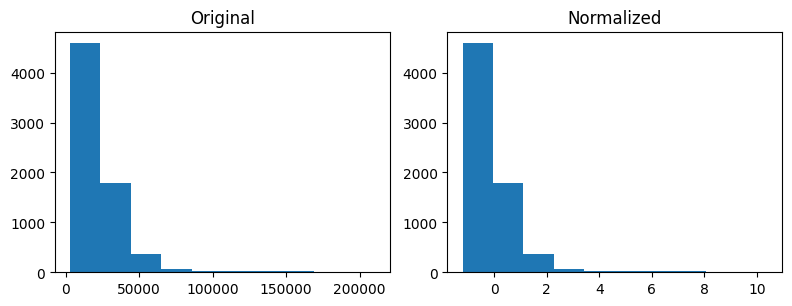

In [4]:
#Check the distribution of output
Oahe = np.array(df['Oahe'].values).T
target_mean = Oahe.mean()
target_std = Oahe.std()
target = (Oahe - target_mean)/target_std
target = target.reshape(len(target),1)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.tight_layout()
ax1.hist(Oahe, 10)
ax2.hist(target, 10)

ax1.set_title('Original')
ax2.set_title('Normalized')
plt.show()

In [5]:
#Normalize the release based on the mean/std of inflow, so they're on the scale
forcing[:,-1] = (forcing[:,-1] - target_mean)/target_std

In [6]:
def reshape_data(x, y, seq_length, lag_time):
    """
    edit from github:https://github.com/kratzert/pangeo_lstm_example/blob/master/LSTM_for_rainfall_runoff_modelling.ipynb

    Reshape matrix data into sample shape for LSTM training.
    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction

    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.

    """
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1 -lag_time, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1 -lag_time, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]      # every y corresponds to x-365:x
        y_new[i, :] = y[i + seq_length - 1 + lag_time, 0]        # on the same day

    return x_new, y_new

In [7]:
from __future__ import print_function
import torch.utils.data as data

class MyDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __getitem__(self, index):
        img, target  = self.images[index], self.labels[index],
        return img, target,

    def __len__(self):
        return len(self.images)

In [8]:
lag_time = 1 # predict one day ahead
r_ds = 8 # Routing days
seq_length = 150 # input length for LSTM

#Split validation period
start_date = pd.to_datetime("2001-01-01", format="%Y-%m-%d")
mid_date = pd.to_datetime("2005-12-31", format="%Y-%m-%d")
mid_date = mid_date + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, mid_date)
lens1 = len(date_range[seq_length+lag_time-1:])

#Split training period
mid_date2 = pd.to_datetime("2006-01-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2015-12-31", format="%Y-%m-%d")
date_range = pd.date_range(mid_date2, end_date)
lens2 = len(date_range)

In [9]:
input_size = forcing.shape[1] - 1
x, y = reshape_data(forcing, target, seq_length, lag_time)

#Prepare traing/validation/test data
x_train = x[lens1:lens1+lens2]
x_val = x[:lens1]
x_tst = x[lens1+lens2:]
y_val = y[:lens1]
y_train = y[lens1:lens1+lens2]
y_tst = y[lens1+lens2:]

x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
x_tst = torch.from_numpy(x_tst.astype(np.float32))
y_tst = torch.from_numpy(y_tst.astype(np.float32))

ds_train = MyDataset(x_train, y_train)
ds_val = MyDataset(x_val, y_val)
ds_tst = MyDataset(x_tst, y_tst)

tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=256, shuffle=False)
tst_loader = DataLoader(ds_tst, batch_size=256, shuffle=False)

In [10]:
class Coefficient(nn.Module):
    '''
      Class to generate static routing coefficients
    '''
    def __init__(self, seq_length, hidden_size):
        super(Coefficient, self).__init__()
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.pos_embedding = nn.Parameter(torch.Tensor(1, self.seq_length))
        self.softmax = nn.Softmax(dim=1)

    def forward(self):
        coeff = self.pos_embedding
        coeff = self.softmax(coeff)

        return coeff

In [11]:
class Model(nn.Module):

    def __init__(self, feature, hidden_size, dropout_rate: float=0.0):

        super(Model, self).__init__()
        self.input_size = feature
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        self.lstm = nn.LSTM(self.input_size, self.hidden_size,
                            num_layers=2, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size*2)
        self.fc3 = nn.Linear(self.hidden_size*2, out_features=1)
        #self.coeff = Coefficient(r_ds, self.hidden_size)
        self.conv1 = nn.Conv1d(r_ds*2, r_ds,1)
        self.fc4 = nn.Linear(self.hidden_size, 1)
        self.softmax = torch.nn.Softmax(dim=1)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.LSTM):
          nn.init.orthogonal_(m.weight_ih_l0)
          nn.init.eye_(m.weight_hh_l0 )
          nn.init.constant_(m.bias_ih_l0, 0)
          nn.init.constant_(m.bias_hh_l0 , 0)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x[:,:,0:-1])

        #precipitation-runoff
        pred = self.fc2(h_n[-1,:,:])
        pred = self.fc3(self.dropout(F.tanh(pred)))

        #routing
        temp = F.gelu(self.conv1(output[:,-r_ds*2:, :]))
        temp = F.gelu(self.fc4(temp)).reshape(-1, r_ds)
        coeff = self.softmax(temp)
        routing = (x[:,-r_ds:,-1]*coeff).sum(axis=1)

        #precipitation-runoff + routing
        inflow = pred + torch.unsqueeze(routing, 1)

        return inflow, pred, torch.unsqueeze(routing, 1)

In [12]:
def train_epoch(model, optimizer, loader, loss_func, epoch):

    # set model to train mode
    model.train()
    pbar = tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    loss_train = 0
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat, _, _ = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")
        loss_train += loss.item()

    learning_rate.append(optimizer.state_dict()['param_groups'][0]['lr'])
    tr=loss_train/len(pbar)
    train_losses.append(tr)


def eval_model(model, loader):

    # set model to eval mode
    model.eval()
    obs = []
    preds = []
    p_r = []
    routing = []

    with torch.no_grad():
        # request mini-batch of data from the loader
        loss_val=0
        for xs, ys in loader:
            # push data to GPU (if available)
            xs, ys = xs.to(DEVICE), ys.to(DEVICE)
            # get model predictions
            y_hat, p_rt, routingt = model(xs)
            #calculate loss
            loss = loss_func(y_hat, ys)
            obs.append(ys)
            preds.append(y_hat)
            p_r.append(p_rt)
            routing.append(routingt)
            loss_val += loss.item()

    te=loss_val/len(loader)
    val_losses.append(te)

    return torch.cat(obs), torch.cat(preds), torch.cat(p_r), torch.cat(routing), te

def calc_nse(obs, sim):
    '''
    Calculate Nash-Sutcliff-Efficiency and correlation.

    '''
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    corr_val = np.corrcoef(sim.T,obs.T)[0,1]

    return nse_val, corr_val

In [13]:
hidden_size = 40
dropout_rate = 0.25
learning_rate = 1e-3
model = Model(input_size, hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
#model = torch.compile(model)
n_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

In [14]:
sys.path.append('/content/drive/MyDrive/Hybrid paper/earlystopping')

In [15]:
from pytorchtools import *
train_losses=[]
val_losses=[]
learning_rate=[]
early_stopping = EarlyStopping(patience=30, verbose=True)
for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader , loss_func, i+1)
    obs, preds, p_r, rounting, te = eval_model(model, val_loader)
    obs = obs.cpu().numpy()*target_std+target_mean
    preds = preds.cpu().numpy()*target_std+target_mean
    nse = calc_nse(obs, preds)
    tqdm.write(f"Validation NSE: {nse[0]:.2f}, Validation Corr: {nse[1]:.2f}")
    early_stopping(te, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

model.load_state_dict(torch.load('/content/drive/MyDrive/Hybrid paper/earlystopping/checkpoint.pt'))

  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.42, Validation Corr: 0.77
Validation loss decreased (inf --> 0.095273).  Saving model ...


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.19, Validation Corr: 0.70
Validation loss decreased (0.095273 --> 0.053378).  Saving model ...


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.02, Validation Corr: 0.62
EarlyStopping counter: 1 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.17, Validation Corr: 0.66
EarlyStopping counter: 2 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -1.21, Validation Corr: 0.55
EarlyStopping counter: 3 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.47, Validation Corr: 0.62
EarlyStopping counter: 4 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.15, Validation Corr: 0.66
EarlyStopping counter: 5 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.98, Validation Corr: 0.62
EarlyStopping counter: 6 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.11, Validation Corr: 0.66
EarlyStopping counter: 7 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.24, Validation Corr: 0.65
EarlyStopping counter: 8 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.21, Validation Corr: 0.68
Validation loss decreased (0.053378 --> 0.050203).  Saving model ...


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.15, Validation Corr: 0.69
EarlyStopping counter: 1 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.21, Validation Corr: 0.68
EarlyStopping counter: 2 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.47, Validation Corr: 0.74
Validation loss decreased (0.050203 --> 0.033763).  Saving model ...


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.09, Validation Corr: 0.66
EarlyStopping counter: 1 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.15, Validation Corr: 0.66
EarlyStopping counter: 2 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.36, Validation Corr: 0.70
EarlyStopping counter: 3 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.14, Validation Corr: 0.64
EarlyStopping counter: 4 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.05, Validation Corr: 0.65
EarlyStopping counter: 5 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.22, Validation Corr: 0.67
EarlyStopping counter: 6 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.14, Validation Corr: 0.66
EarlyStopping counter: 7 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.04, Validation Corr: 0.64
EarlyStopping counter: 8 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.26, Validation Corr: 0.67
EarlyStopping counter: 9 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.06, Validation Corr: 0.63
EarlyStopping counter: 10 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.22, Validation Corr: 0.65
EarlyStopping counter: 11 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.03, Validation Corr: 0.65
EarlyStopping counter: 12 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.00, Validation Corr: 0.61
EarlyStopping counter: 13 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.21, Validation Corr: 0.66
EarlyStopping counter: 14 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.27, Validation Corr: 0.63
EarlyStopping counter: 15 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.01, Validation Corr: 0.66
EarlyStopping counter: 16 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.16, Validation Corr: 0.68
EarlyStopping counter: 17 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.07, Validation Corr: 0.63
EarlyStopping counter: 18 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.07, Validation Corr: 0.66
EarlyStopping counter: 19 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.05, Validation Corr: 0.63
EarlyStopping counter: 20 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.15, Validation Corr: 0.63
EarlyStopping counter: 21 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.19, Validation Corr: 0.67
EarlyStopping counter: 22 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.19, Validation Corr: 0.65
EarlyStopping counter: 23 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.03, Validation Corr: 0.64
EarlyStopping counter: 24 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.16, Validation Corr: 0.65
EarlyStopping counter: 25 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.05, Validation Corr: 0.64
EarlyStopping counter: 26 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.21, Validation Corr: 0.68
EarlyStopping counter: 27 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.02, Validation Corr: 0.65
EarlyStopping counter: 28 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: -0.06, Validation Corr: 0.61
EarlyStopping counter: 29 out of 30


  0%|          | 0/15 [00:00<?, ?it/s]

Validation NSE: 0.17, Validation Corr: 0.67
EarlyStopping counter: 30 out of 30
Early stopping


<All keys matched successfully>

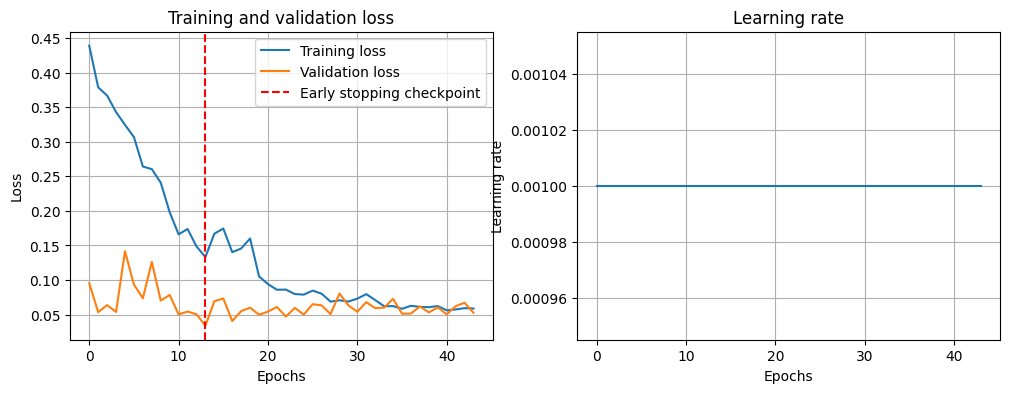

In [16]:
fig = plt.figure()
fig.set_size_inches(12,4)
ax1 = fig.add_subplot(121)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
minposs = val_losses.index(min(val_losses))
plt.axvline(minposs, linestyle='--', color='r',label='Early stopping checkpoint')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

ax1 = fig.add_subplot(122)
plt.plot(learning_rate, label='Training loss')
plt.title('Learning rate')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.grid(True)

In [17]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/Hybrid paper/earlystopping/Oahe.pt'))

<All keys matched successfully>

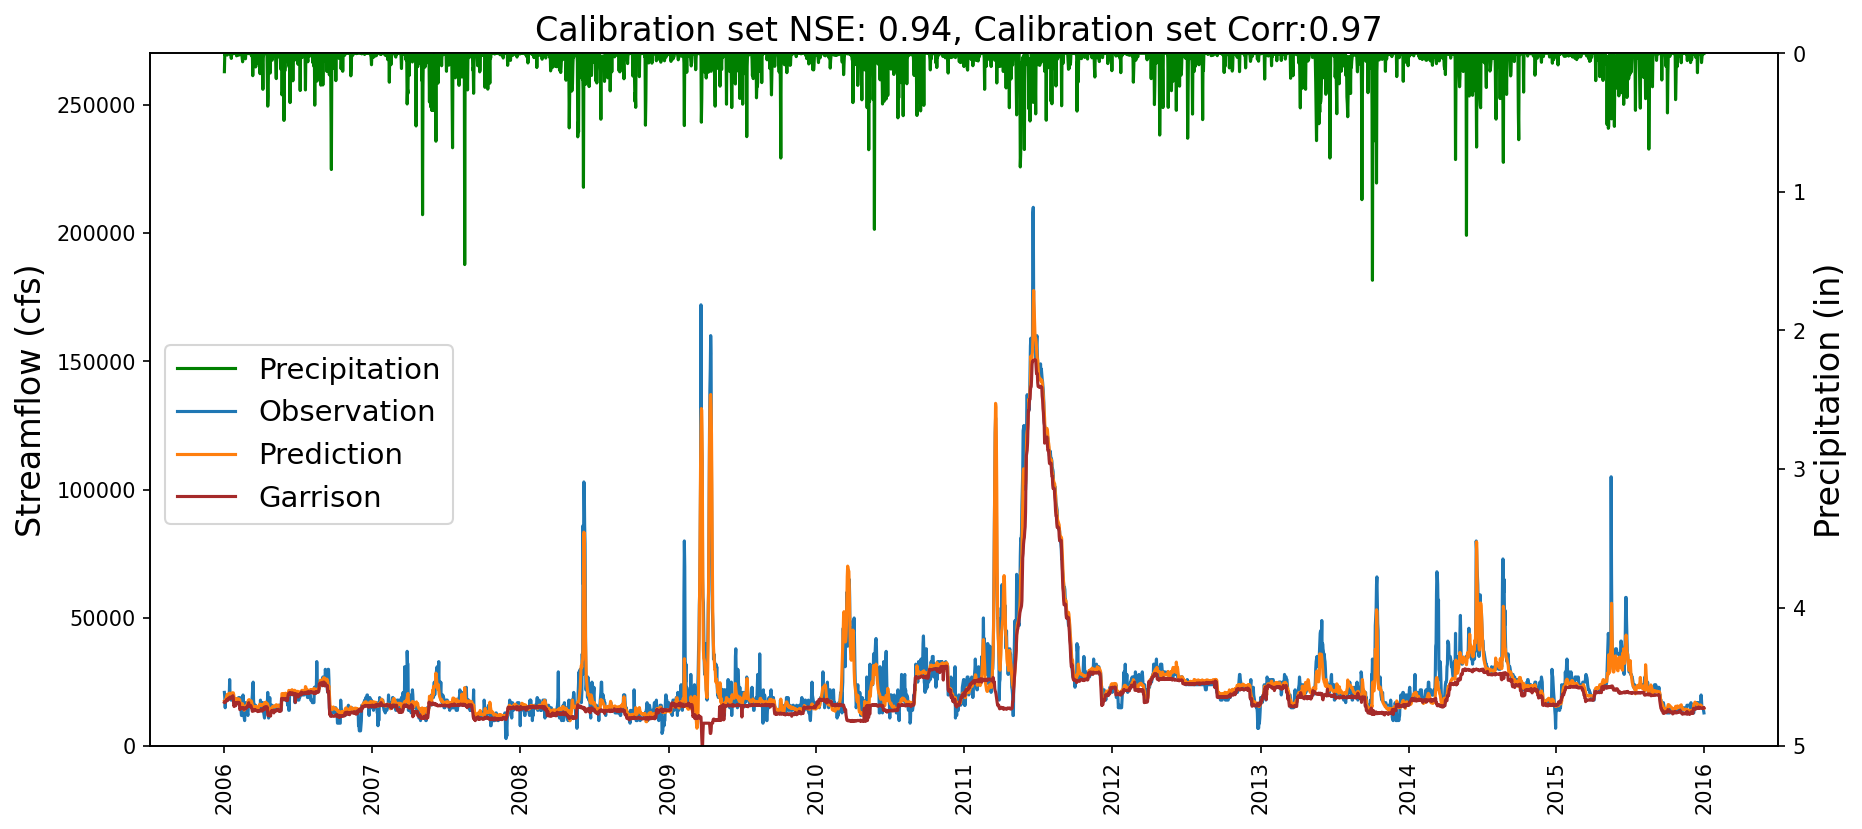

In [18]:
# Evaluate on training set
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=False)
obs, preds, _, _, _ = eval_model(model, tr_loader)
obs = obs.cpu().numpy()*target_std+target_mean
preds = preds.cpu().numpy()*target_std+target_mean
nse = calc_nse(obs, preds)

# Plot results
start_date = pd.to_datetime("2006-01-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2015-12-31", format="%Y-%m-%d")
end_date = end_date + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

fig = plt.figure(figsize=(14, 6), dpi=150)
ax = fig.add_subplot()
lns1 = ax.plot(date_range[:-lag_time], obs, label="Observation")
lns2 = ax.plot(date_range[:-lag_time], preds, label="Prediction")
lns3 = ax.plot(date_range[:-lag_time], x_train[:,-1,-1]*target_std+target_mean, 'brown', label="Garrison")
ax.axis(ymin=0,ymax=270000)
ax.set_title(f"Calibration set NSE: {nse[0]:.2f}, Calibration set Corr:{nse[1]:.2f} ", fontsize=16)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("Streamflow (cfs)",fontsize=16)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns4 = ax2.plot(date_range[:-lag_time], (x_train[:,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1),'g',label="Precipitation")
ax2.axis(ymin=0,ymax=5)
ax2.invert_yaxis()
ax2.set_ylabel("Precipitation (in)",fontsize=16)
lns = lns4+lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=6, fontsize=14, bbox_to_anchor=(0, 0.45))

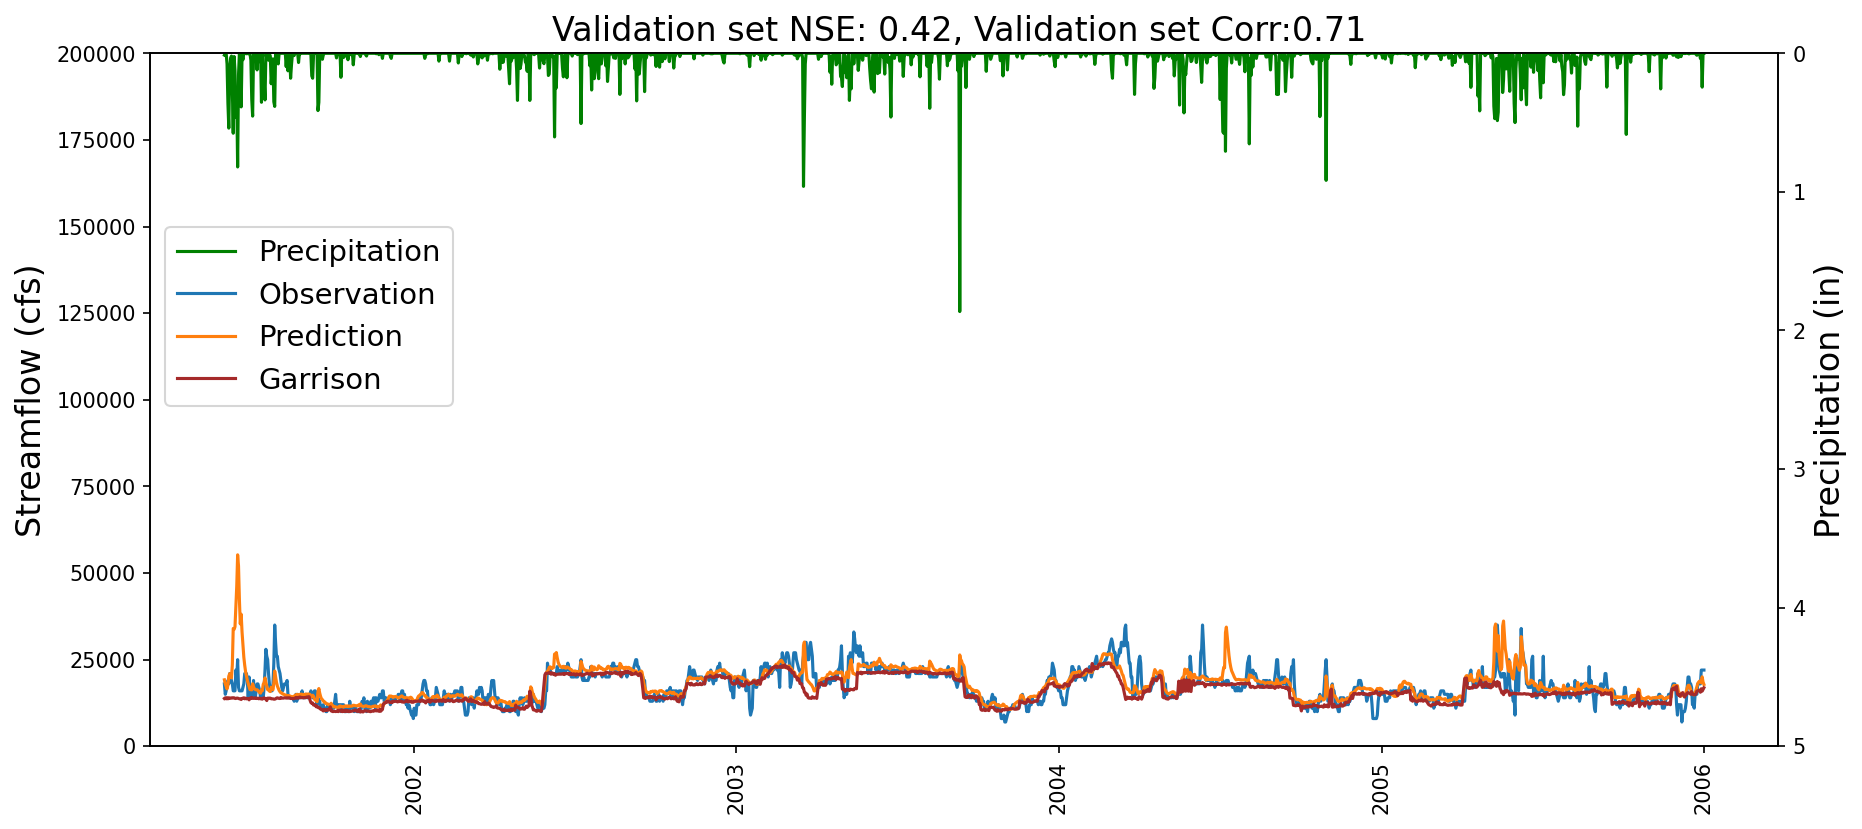

In [19]:
# Evaluate on validation set
obs, preds, _, _, _ = eval_model(model, val_loader)
obs = obs.cpu().numpy()*target_std+target_mean
preds = preds.cpu().numpy()*target_std+target_mean
nse = calc_nse(obs, preds)

# Plot results
start_date = pd.to_datetime("2001-01-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2005-12-31", format="%Y-%m-%d")
end_date = end_date + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

fig = plt.figure(figsize=(14, 6), dpi=150)
ax = fig.add_subplot()

lns1 = ax.plot(date_range[seq_length+lag_time-1:], obs, label="Observation")
lns2 = ax.plot(date_range[seq_length+lag_time-1:], preds, label="Prediction")
lns3 = ax.plot(date_range[seq_length+lag_time-1:], x_val[:,-1,-1]*target_std+target_mean,'brown', label="Garrison")
ax.axis(ymin=0,ymax=200000)
ax.set_title(f"Validation set NSE: {nse[0]:.2f}, Validation set Corr:{nse[1]:.2f} ", fontsize=16)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("Streamflow (cfs)",fontsize=16)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns4 = ax2.plot(date_range[seq_length+lag_time-1:], (x_val[:,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1),'g',label="Precipitation")
ax2.axis(ymin=0,ymax=5)
ax2.invert_yaxis()
ax2.set_ylabel("Precipitation (in)",fontsize=16)
lns = lns4+lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=6, fontsize=14, bbox_to_anchor=(0, 0.62))

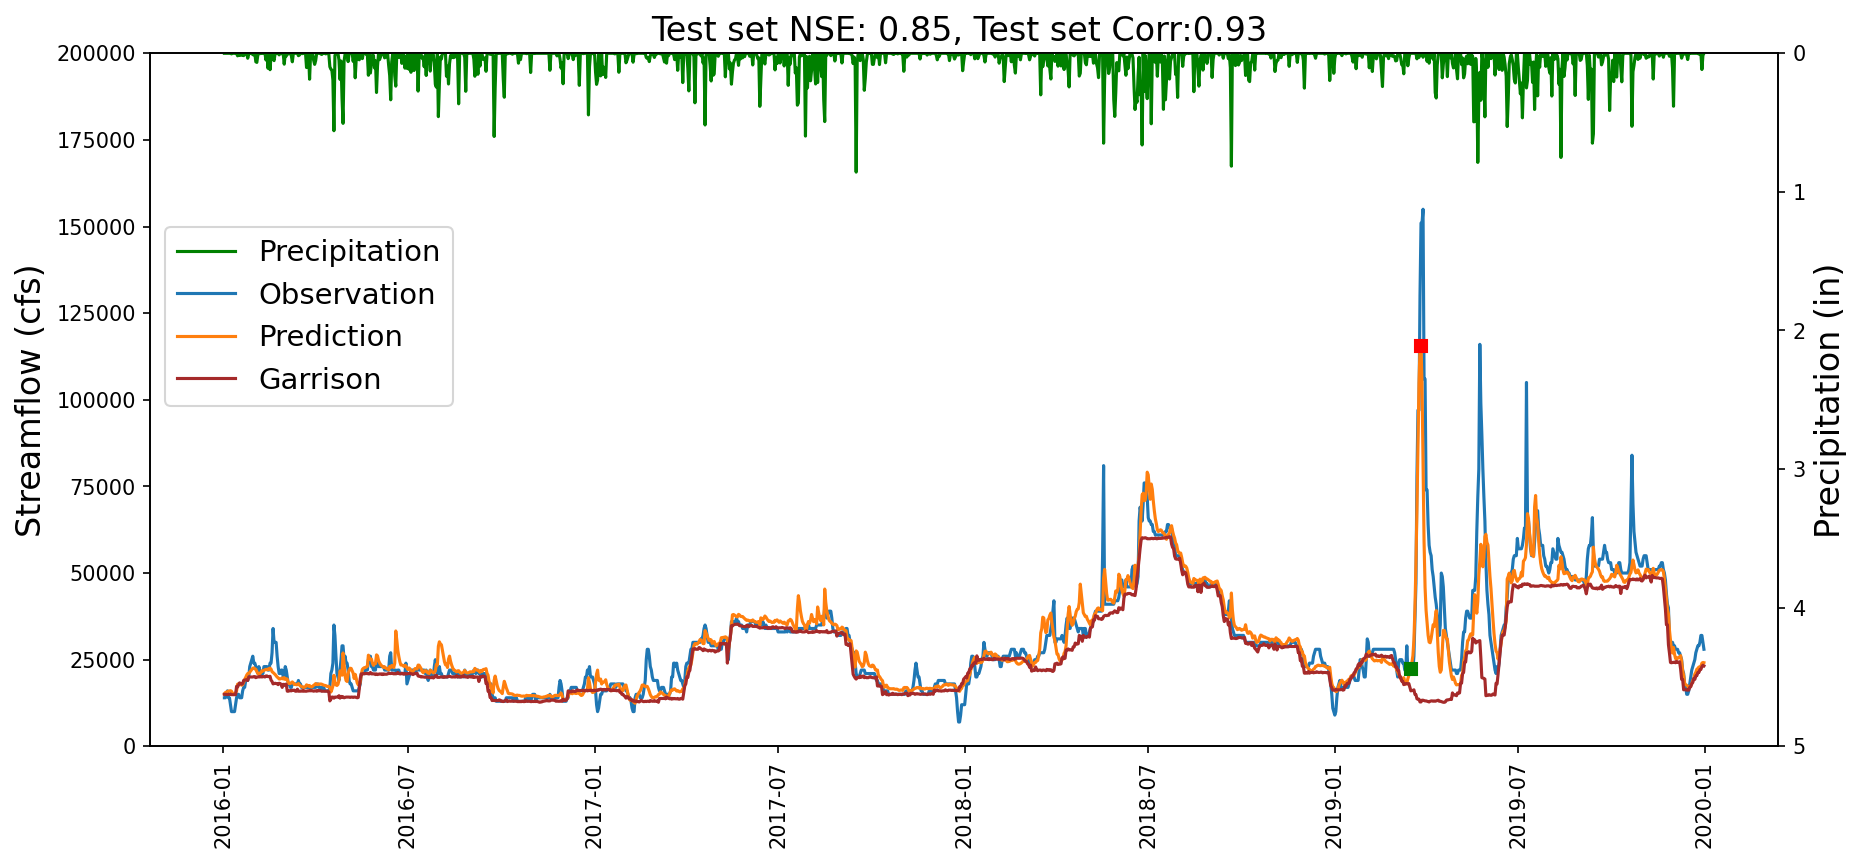

In [20]:
# Evaluate on test set
obs, preds, r_r, routing, _ = eval_model(model, tst_loader)
obs = obs.cpu().numpy()*target_std+target_mean
preds = preds.cpu().numpy()*target_std+target_mean
nse = calc_nse(obs, preds)

# Plot results
start_date = pd.to_datetime("2016-01-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2019-12-31", format="%Y-%m-%d")
#end_date = end_date + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)

fig = plt.figure(figsize=(14, 6), dpi=150)
ax = fig.add_subplot()

lns1 = ax.plot(date_range[1:], obs, label="Observation")
lns2 = ax.plot(date_range[1:], preds, label="Prediction")
lns3 = ax.plot(date_range[1:], x_tst[:,-1,-1]*target_std+target_mean,'brown', label="Garrison")
lns5 = ax.plot(date_range[1171], preds[1170,0], 's', c='green')
lns5 = ax.plot(date_range[1181], preds[1180,0], 's', c='red')

ax.axis(ymin=0,ymax=200000)
ax.set_title(f"Test set NSE: {nse[0]:.2f}, Test set Corr:{nse[1]:.2f} ", fontsize=16)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("Streamflow (cfs)",fontsize=16)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
lns4 = ax2.plot(date_range[1:], (x_tst[:,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1),'g',label="Precipitation")
ax2.axis(ymin=0,ymax=5)
ax2.invert_yaxis()
ax2.set_ylabel("Precipitation (in)",fontsize=16)
lns = lns4+lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=6, fontsize=14, bbox_to_anchor=(0, 0.62))

In [21]:
output, (h_n, c_n) = model.lstm(x_tst[:,:,0:-1].to(DEVICE))
pred = model.fc2(h_n[-1,:,:])
pred = model.fc3(model.dropout(F.tanh(pred)))

#routing
temp = F.gelu(model.conv1(output[:,-r_ds*2:, :]))
temp = F.gelu(model.fc4(temp)).reshape(-1, r_ds)
coeff = model.softmax(temp)

11.161443 7.870222


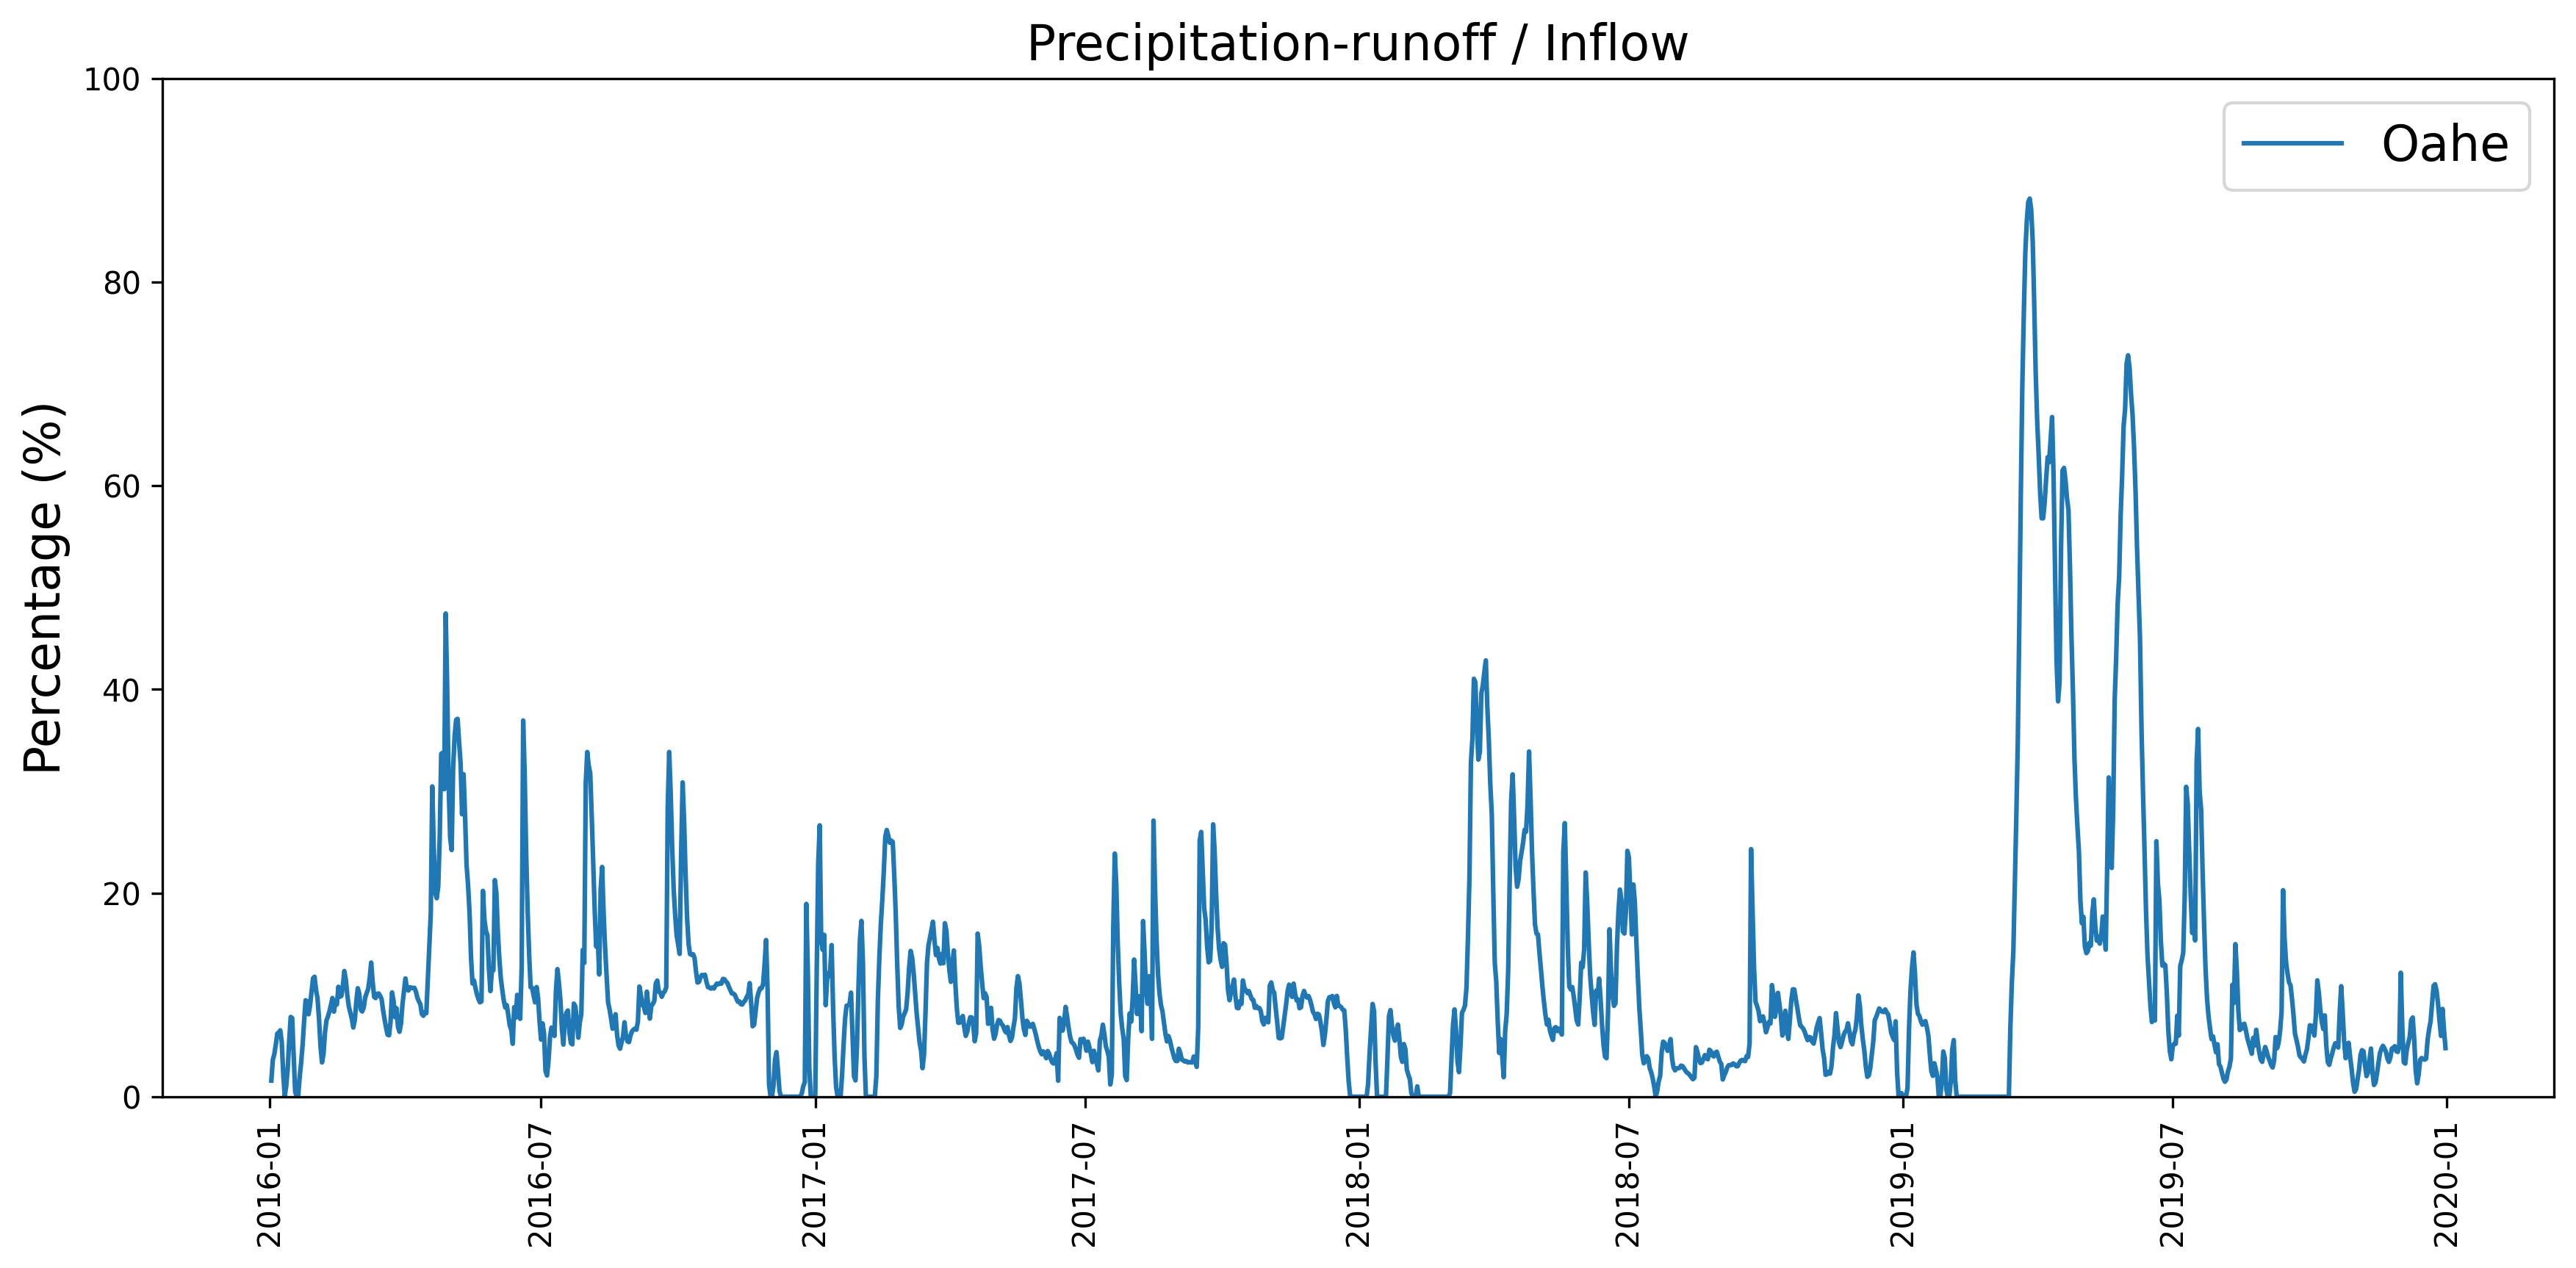

In [22]:
obss, predss, p_r, routing, _ = eval_model(model, tst_loader)
p_r = p_r.cpu().numpy()
routing = routing.cpu().numpy()
obss = obss.cpu().numpy()
predss = predss.cpu().numpy()

#routingb = routing*target_std+target_mean
#value = (1- routingb/preds)*100

thresh = (0 - target_mean)/target_std # calculate the value of 0 after normalization
predss = predss - thresh
value = (p_r/predss)*100

value = np.where(value >= 0, value, 0)
fig = plt.figure(figsize=(14, 6), dpi=300)
ax = fig.add_subplot()
lns1 = ax.plot(date_range[1:], value, label='Oahe')
ax.axis(ymin=0,ymax=100)
ax.set_title("Precipitation-runoff / Inflow", fontsize=16)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("Percentage (%)",fontsize=16)
plt.legend(fontsize=16)
print(value.mean(), np.median(value))

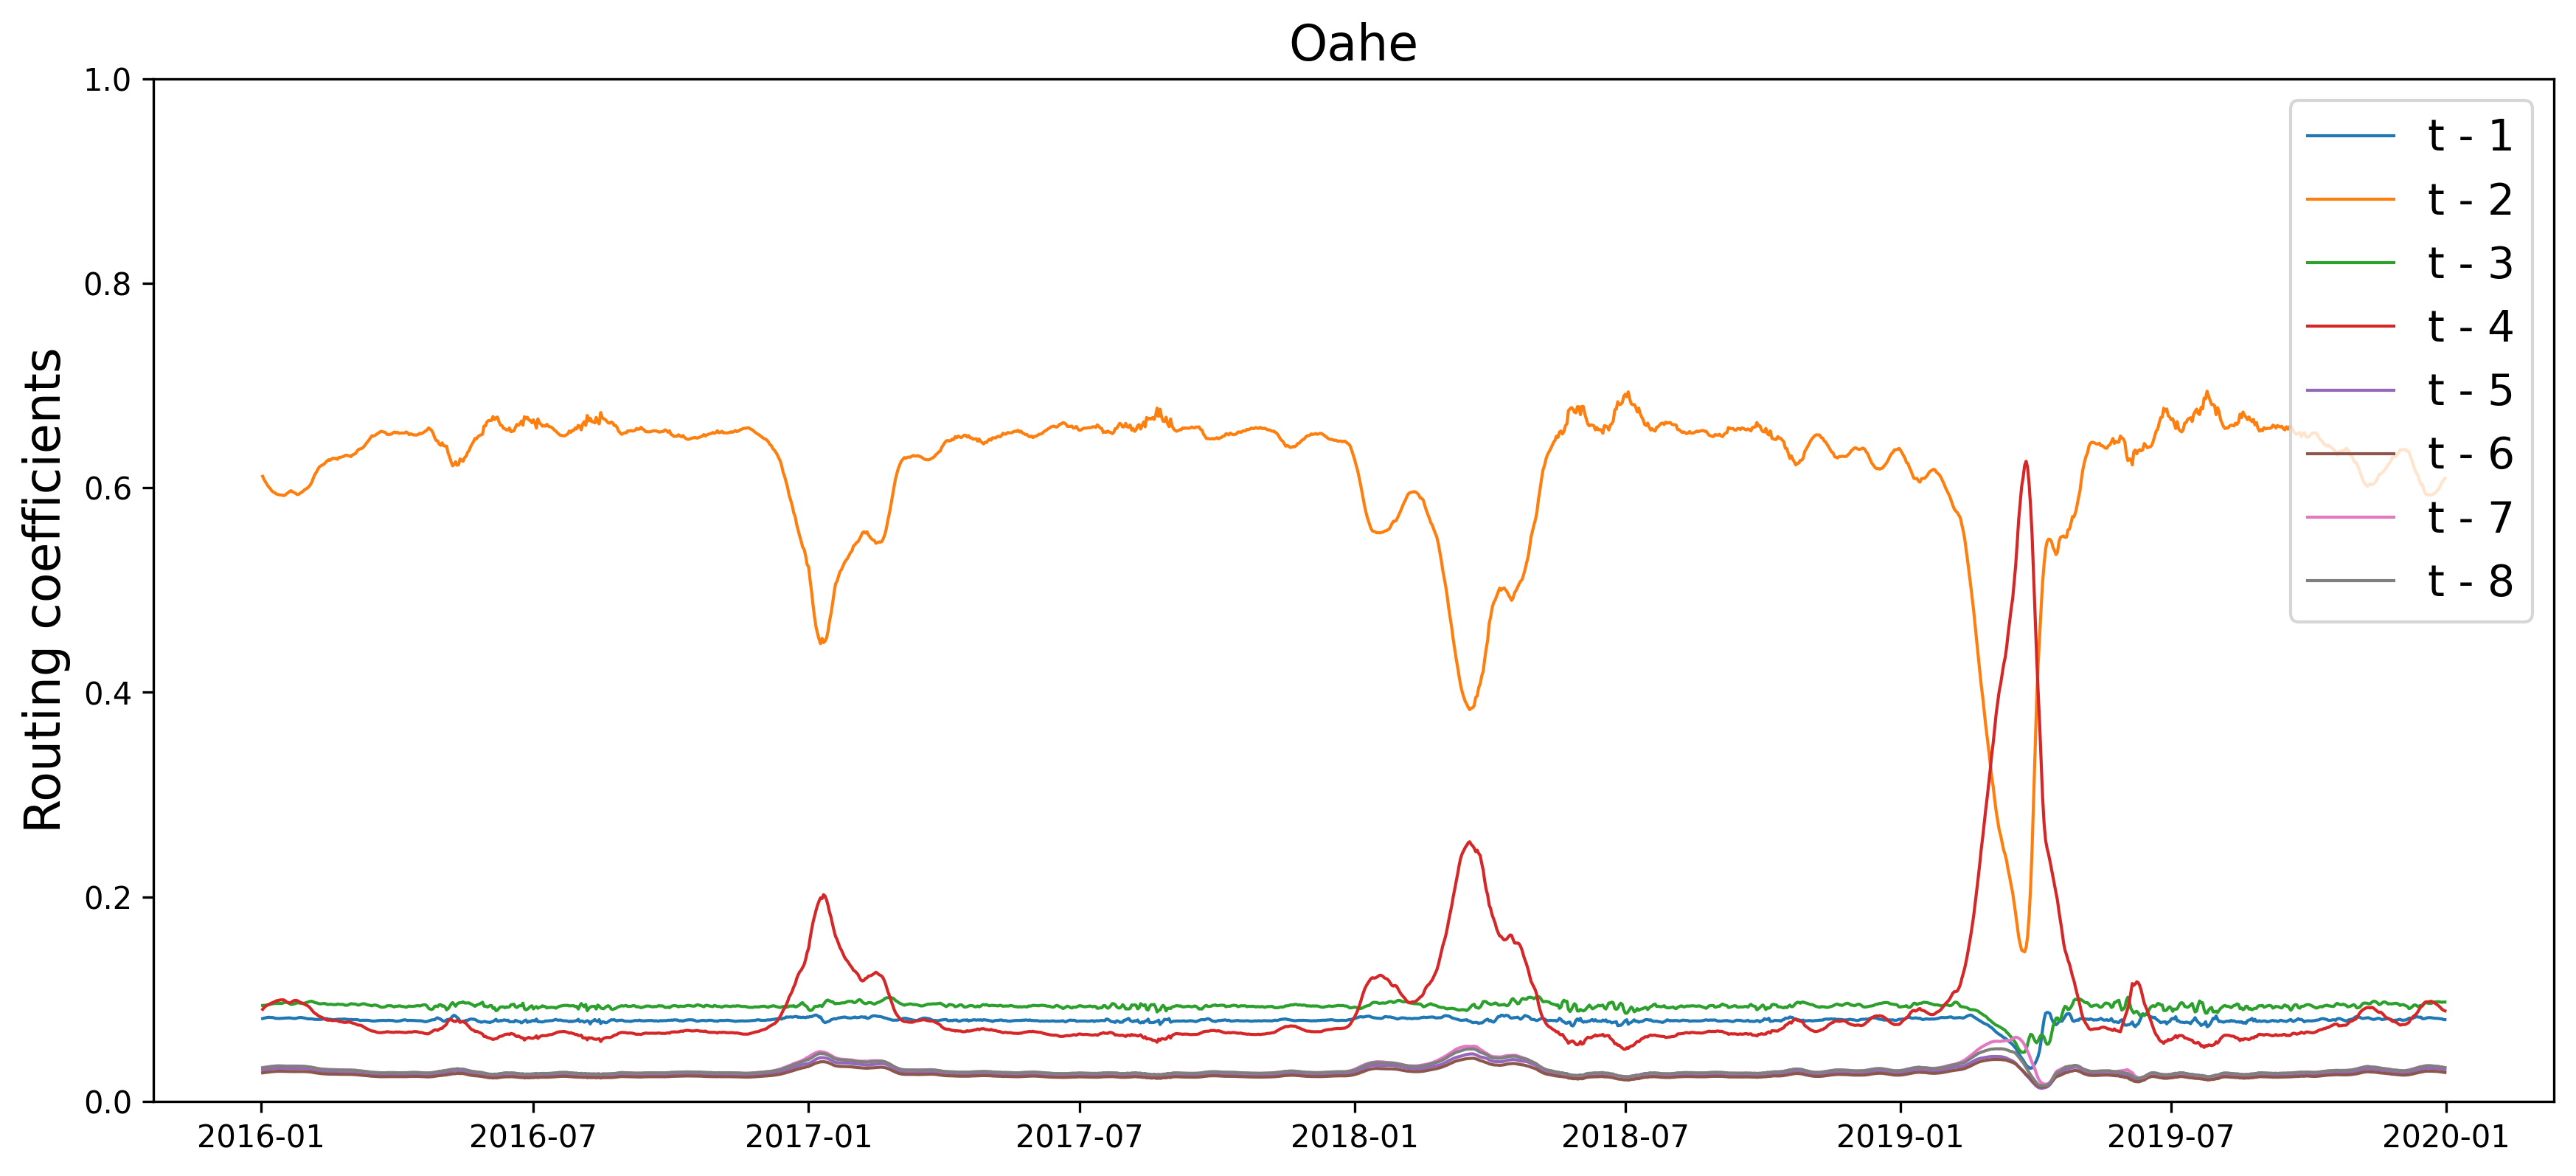

In [23]:
coeff = coeff.cpu().detach().numpy()
fig = plt.figure(figsize=(14, 6), dpi=300)
ax = fig.add_subplot()
lns1 = ax.plot(date_range[1:], coeff[:,-1], label="t - 1", linewidth=1)
lns2 = ax.plot(date_range[1:], coeff[:,-2], label="t - 2", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-3], label="t - 3", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-4], label="t - 4", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-5], label="t - 5", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-6], label="t - 6", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-7], label="t - 7", linewidth=1)
lns3 = ax.plot(date_range[1:], coeff[:,-8], label="t - 8", linewidth=1)
ax.axis(ymin=0,ymax=1)
plt.title('Oahe', fontsize =16)
plt.ylabel('Routing coefficients', fontsize =16)
plt.legend(fontsize =14)

In [24]:
oahe = np.zeros((len(preds),5))
oahe[:, 0] = preds[:,0]
oahe[:, 1] = obs[:,0]
oahe[:, 2] = x_tst[:,-1,-1]*target_std+target_mean
oahe[:, 3] = (x_tst[:,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1)
oahe[:, 4] = value[:,0]

oahe = pd.DataFrame(oahe, columns=['preds', 'obs', 'garrison', 'precipitation', 'percent'])
oahe.head()

,preds,obs,garrison,precipitation,percent
0,15141.026367,14000.000977,15000.000977,2.438643e-10,1.582572
1,15519.064453,14000.000977,15000.000977,2.438643e-10,3.608741
2,15631.712891,15000.000977,15000.000977,2.438643e-10,4.182588
3,15790.927734,16000.000977,14900.000977,2.438643e-10,5.116422
4,15917.641602,14000.000977,15000.000977,2.438643e-10,6.203054


In [25]:
#oahe.to_excel('/content/drive/MyDrive/Hybrid paper/results/oahe_v4.xlsx')

In [26]:
output, (h_n, c_n) = model.lstm(x_tst[:,:,0:9].to(DEVICE))
output = output.cpu().detach().numpy()
h_n = h_n.cpu().detach().numpy()
c_n = c_n.cpu().detach().numpy()

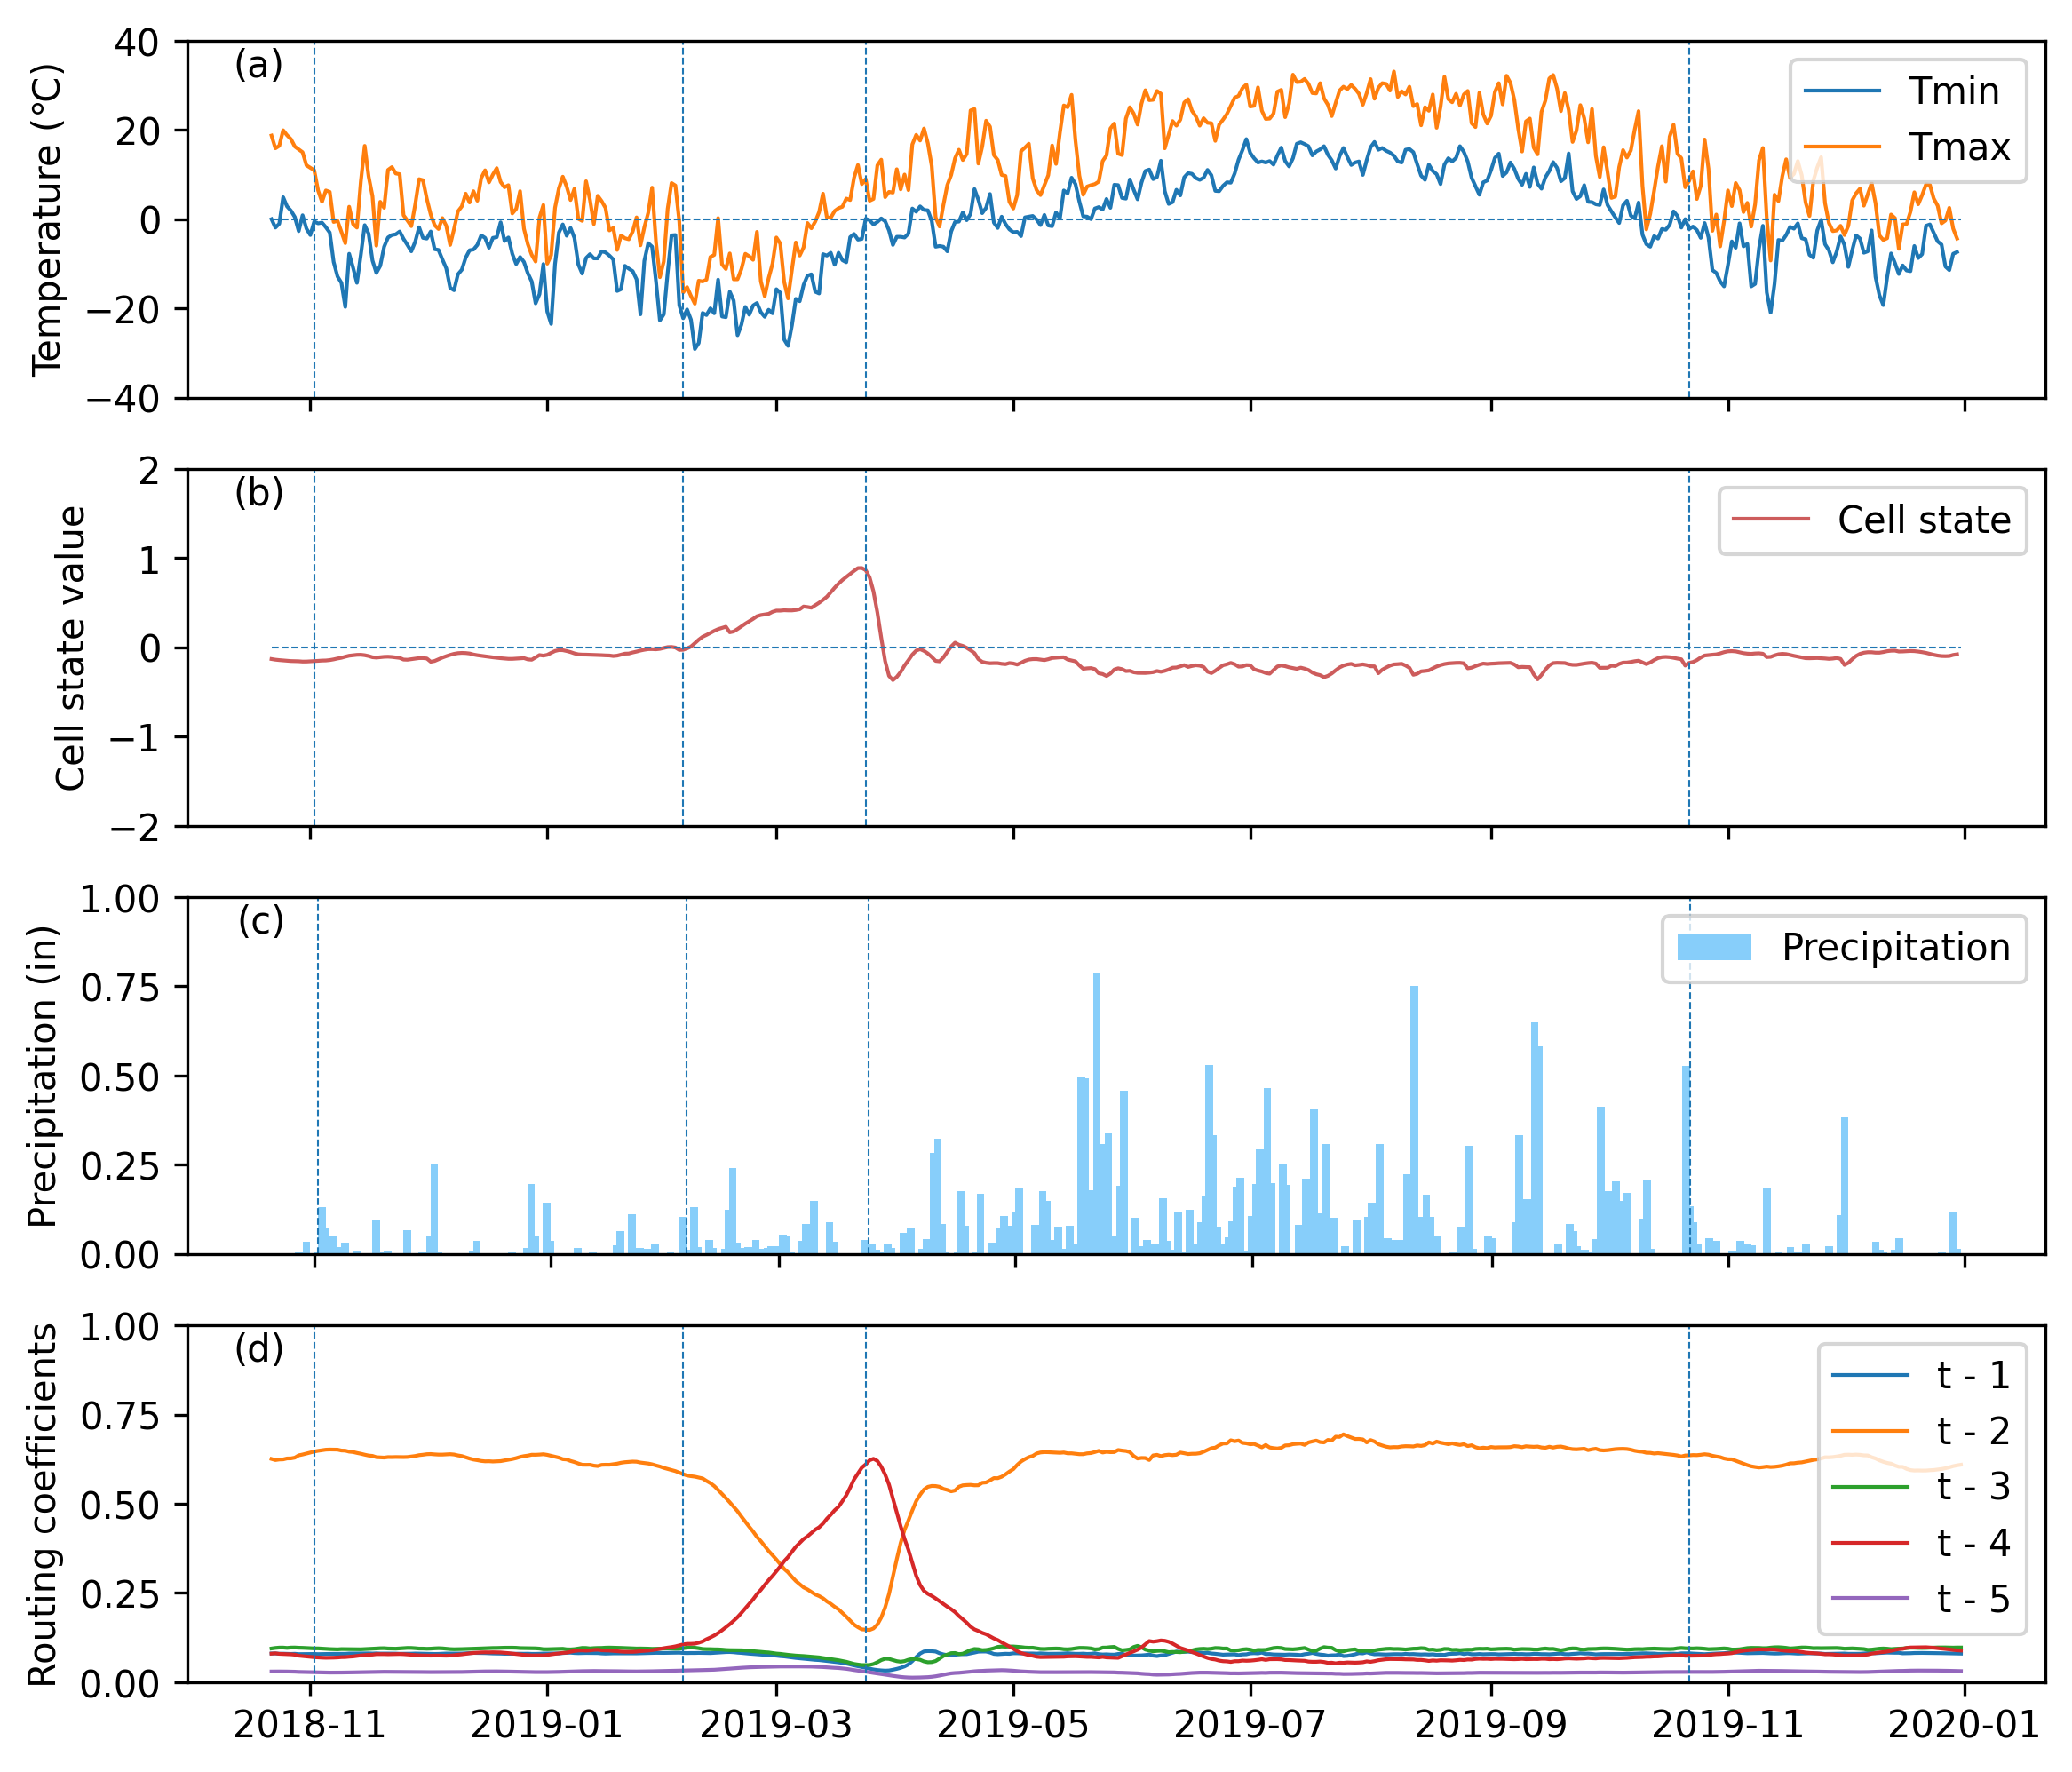

In [27]:
fig = plt.figure(figsize=(9, 8), dpi=300)
ax = fig.add_subplot(411)
Fmin, Fmax = x_tst[1024:-1,-1,-2]*forcing_std[-2]+forcing_mean[-2], x_tst[1024:-1,-1,-3]*forcing_std[-3]+forcing_mean[-3]
ax.plot(date_range[1025:-1], (Fmin-32)/1.8, label="Tmin",  linewidth=1)
ax.plot(date_range[1025:-1], (Fmax-32)/1.8, label="Tmax",  linewidth=1)
ax.text(date_range[1015], 32, '(a)', fontsize = 10)
ax.vlines(x=date_range[1036:1037], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[1131:1132], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[1178:1179], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[1390:1391], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.hlines(y=0, xmin=date_range[1025], xmax=date_range[-1], linestyle='dashed', linewidth=0.5)
ax.axis(ymin=-40,ymax=40)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("Temperature (℃)",fontsize=10)
ax.legend(loc='upper right',fontsize=10)
plt.tick_params('x', labelbottom=False)

ax2 = fig.add_subplot(412)
ax2.plot(date_range[1025:-1], c_n[-1, 1024:-1, 33], label="Cell state", color='indianred', linewidth=1)   #26,31
ax2.text(date_range[1015], 1.6, '(b)', fontsize = 10)
ax2.vlines(x=date_range[1036:1037], ymin=-2, ymax=3, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[1131:1132], ymin=-2, ymax=3, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[1178:1179], ymin=-2, ymax=3, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[1390:1391], ymin=-2, ymax=3, linestyle='dashed', linewidth=0.5)
ax2.hlines(y=0, xmin=date_range[1025], xmax=date_range[-1], linestyle='dashed', linewidth=0.5)
ax2.xaxis.set_tick_params(rotation=90)
ax2.axis(ymin=-2,ymax=2)
ax2.set_ylabel("Cell state value",fontsize=10)
ax2.legend(fontsize=10)
plt.tick_params('x', labelbottom=False)

ax3=fig.add_subplot(413)
ax3.bar(date_range[1025:-1], (x_tst[1024:-1,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1),width=2, color = 'lightskyblue',label="Precipitation")
ax3.text(date_range[1015], 0.9, '(c)', fontsize = 10)
ax3.vlines(x=date_range[1036:1037], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[1131:1132], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[1178:1179], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[1390:1391], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.axis(ymin=0,ymax=1)
ax3.set_ylabel("Precipitation (in)",fontsize=10)
plt.tick_params('x', labelbottom=False)
ax3.legend(fontsize=10)

ax4=fig.add_subplot(414)
ax4.plot(date_range[1025:], coeff[1024:,-1], label="t - 1", linewidth=1)
ax4.plot(date_range[1025:], coeff[1024:,-2], label="t - 2", linewidth=1)
ax4.plot(date_range[1025:], coeff[1024:,-3], label="t - 3", linewidth=1)
ax4.plot(date_range[1025:], coeff[1024:,-4], label="t - 4", linewidth=1)
ax4.plot(date_range[1025:], coeff[1024:,-5], label="t - 5", linewidth=1)
ax4.vlines(x=date_range[1036:1037], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax4.vlines(x=date_range[1131:1132], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax4.vlines(x=date_range[1178:1179], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax4.vlines(x=date_range[1390:1391], ymin=0, ymax=1, linestyle='dashed', linewidth=0.5)
ax4.text(date_range[1015], 0.9, '(d)', fontsize = 10)
ax4.axis(ymin=0,ymax=1)
ax4.set_ylabel('Routing coefficients', fontsize =10)
ax4.legend(fontsize =10)
#plt.tight_layout()

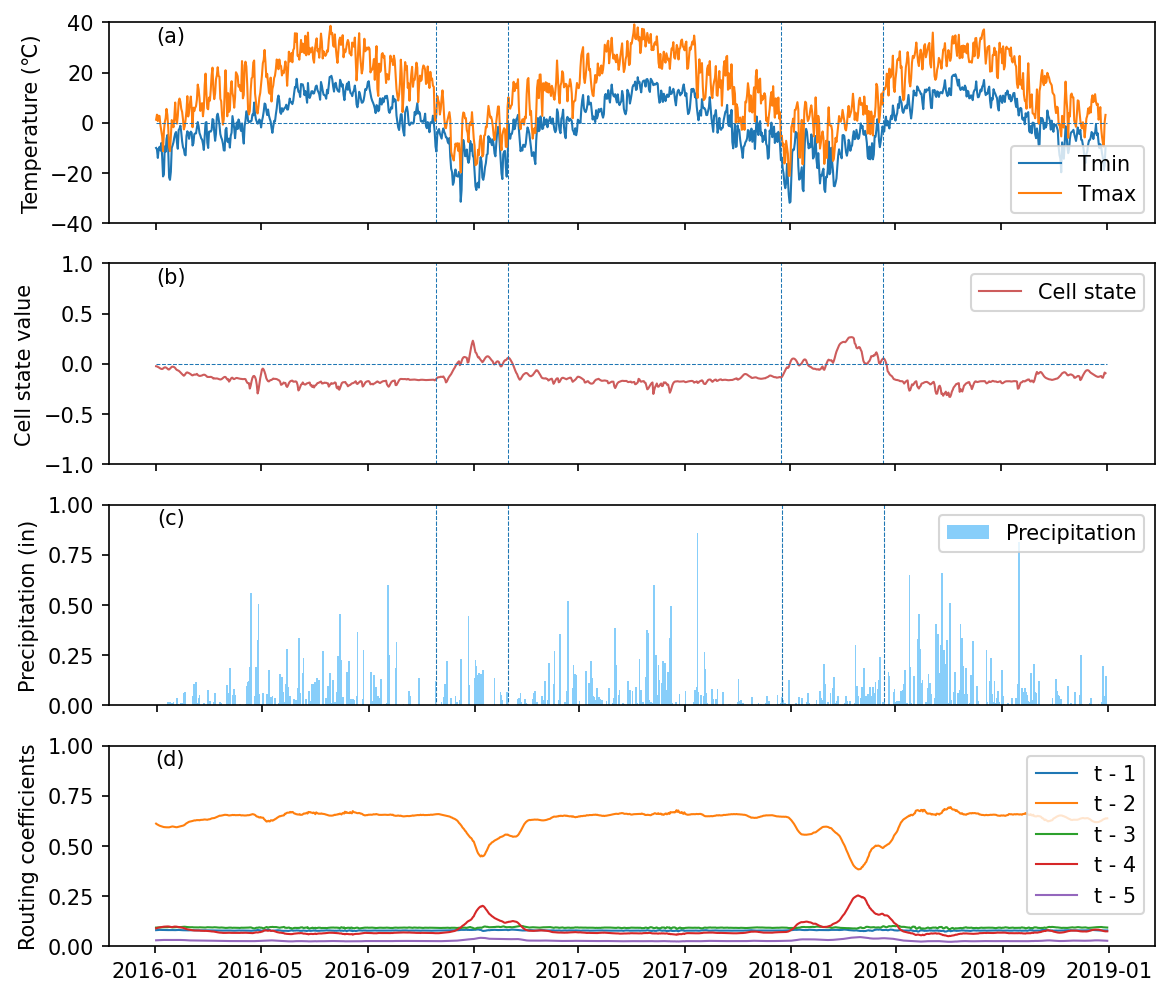

In [28]:
fig = plt.figure(figsize=(9, 8), dpi=150)
ax = fig.add_subplot(411)
Fmin, Fmax = x_tst[0:-365,-1,-2]*forcing_std[-2]+forcing_mean[-2], x_tst[0:-365,-1,-3]*forcing_std[-3]+forcing_mean[-3]
#fahrenheit to celsius formula C= 5/9 (F-32)
ax.plot(date_range[0:-366], (Fmin-32)/1.8, label="Tmin",  linewidth=1)
ax.plot(date_range[0:-366], (Fmax-32)/1.8, label="Tmax",  linewidth=1)
ax.vlines(x=date_range[322:323], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[405:406], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[720:721], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.vlines(x=date_range[838:839], ymin=-40, ymax=40, linestyle='dashed', linewidth=0.5)
ax.text(date_range[0], 32, '(a)', fontsize = 10)
ax.hlines(y=0, xmin=date_range[0], xmax=date_range[-365], linestyle='dashed', linewidth=0.5)
ax.axis(ymin=-40,ymax=40)
ax.set_ylabel("Temperature (℃)",fontsize=10)
ax.legend(loc='lower right',fontsize=10)
plt.tick_params('x', labelbottom=False)

ax2 = fig.add_subplot(412)
ax2.plot(date_range[0:-366], c_n[-1, 0:-365, 33], label="Cell state", color='indianred', linewidth=1)   #26,31
ax2.vlines(x=date_range[322:323], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[405:406], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[720:721], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax2.vlines(x=date_range[838:839], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax2.text(date_range[0], 0.8, '(b)', fontsize = 10)
ax2.hlines(y=0, xmin=date_range[0], xmax=date_range[-365], linestyle='dashed', linewidth=0.5)
ax2.axis(ymin=-1,ymax=1)
ax2.set_ylabel("Cell state value",fontsize=10)
ax2.legend(fontsize=10)
plt.tick_params('x', labelbottom=False)

ax3=fig.add_subplot(413)
ax3.bar(date_range[0:-366], (x_tst[0:-365,-1,0:7]*forcing_std[0:7]+forcing_mean[0:7]).mean(axis=-1),width=2, color = 'lightskyblue',label="Precipitation")
ax3.vlines(x=date_range[322:323], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[405:406], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[720:721], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[838:839], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.text(date_range[0], 0.9, '(c)', fontsize = 10)
ax3.axis(ymin=0,ymax=1)
ax3.set_ylabel("Precipitation (in)",fontsize=10)
ax3.legend(loc='upper right', fontsize=10)
plt.tick_params('x', labelbottom=False)

ax4=fig.add_subplot(414)
ax4.plot(date_range[1:-366], coeff[0:-366,-1], label="t - 1", linewidth=1)
ax4.plot(date_range[1:-366], coeff[0:-366,-2], label="t - 2", linewidth=1)
ax4.plot(date_range[1:-366], coeff[0:-366,-3], label="t - 3", linewidth=1)
ax4.plot(date_range[1:-366], coeff[0:-366,-4], label="t - 4", linewidth=1)
ax4.plot(date_range[1:-366], coeff[0:-366,-5], label="t - 5", linewidth=1)
ax3.vlines(x=date_range[322:323], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[405:406], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[720:721], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax3.vlines(x=date_range[838:839], ymin=-1, ymax=1, linestyle='dashed', linewidth=0.5)
ax4.text(date_range[0], 0.9, '(d)', fontsize = 10)
ax4.axis(ymin=0,ymax=1)
ax4.set_ylabel('Routing coefficients', fontsize =10)
ax4.legend(fontsize =10)